In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from hmmlearn import hmm
from scipy.signal import savgol_filter
from joblib import dump

from hmm_model2 import HMM # self-implemented local module

%matplotlib inline

### Load Training Data

In [2]:
dir_train = "./2019Proj2_train/"
filenames = np.array(os.listdir(dir_train))
gestures = ["beat3", "beat4", "circle", "eight", "inf", "wave"]

train_lists = {}
for g in gestures:
    train_lists[g] = np.array([t for t in filenames if t.startswith(g)])
    print(g, train_lists[g])

train_X = {}
for g in gestures:
    train_X[g] = []
    for fname in train_lists[g]:
        train_X[g].append(np.genfromtxt(os.path.join(dir_train, fname), delimiter='\t'))
        if len(train_X[g][-1]) > 1000:
            train_X[g][-1] = train_X[g][-1][300:-300]
        else:
            train_X[g][-1] = train_X[g][-1][300:]
        print(fname, train_X[g][-1].shape)
    train_X[g] = np.array(train_X[g])

beat3 ['beat3_01.txt' 'beat3_02.txt' 'beat3_03.txt' 'beat3_06.txt'
 'beat3_08.txt']
beat4 ['beat4_01.txt' 'beat4_03.txt' 'beat4_05.txt' 'beat4_08.txt'
 'beat4_09.txt']
circle ['circle12.txt' 'circle13.txt' 'circle14.txt' 'circle17.txt'
 'circle18.txt']
eight ['eight01.txt' 'eight02.txt' 'eight04.txt' 'eight07.txt' 'eight08.txt']
inf ['inf11.txt' 'inf112.txt' 'inf13.txt' 'inf16.txt' 'inf18.txt']
wave ['wave01.txt' 'wave02.txt' 'wave03.txt' 'wave05.txt' 'wave07.txt']
beat3_01.txt (1620, 7)
beat3_02.txt (2008, 7)
beat3_03.txt (2043, 7)
beat3_06.txt (2265, 7)
beat3_08.txt (2495, 7)
beat4_01.txt (2417, 7)
beat4_03.txt (2488, 7)
beat4_05.txt (1707, 7)
beat4_08.txt (2013, 7)
beat4_09.txt (2409, 7)
circle12.txt (1344, 7)
circle13.txt (1754, 7)
circle14.txt (1533, 7)
circle17.txt (1695, 7)
circle18.txt (1301, 7)
eight01.txt (1791, 7)
eight02.txt (2548, 7)
eight04.txt (2771, 7)
eight07.txt (2033, 7)
eight08.txt (2158, 7)
inf11.txt (1383, 7)
inf112.txt (2779, 7)
inf13.txt (1895, 7)
inf16.txt (152

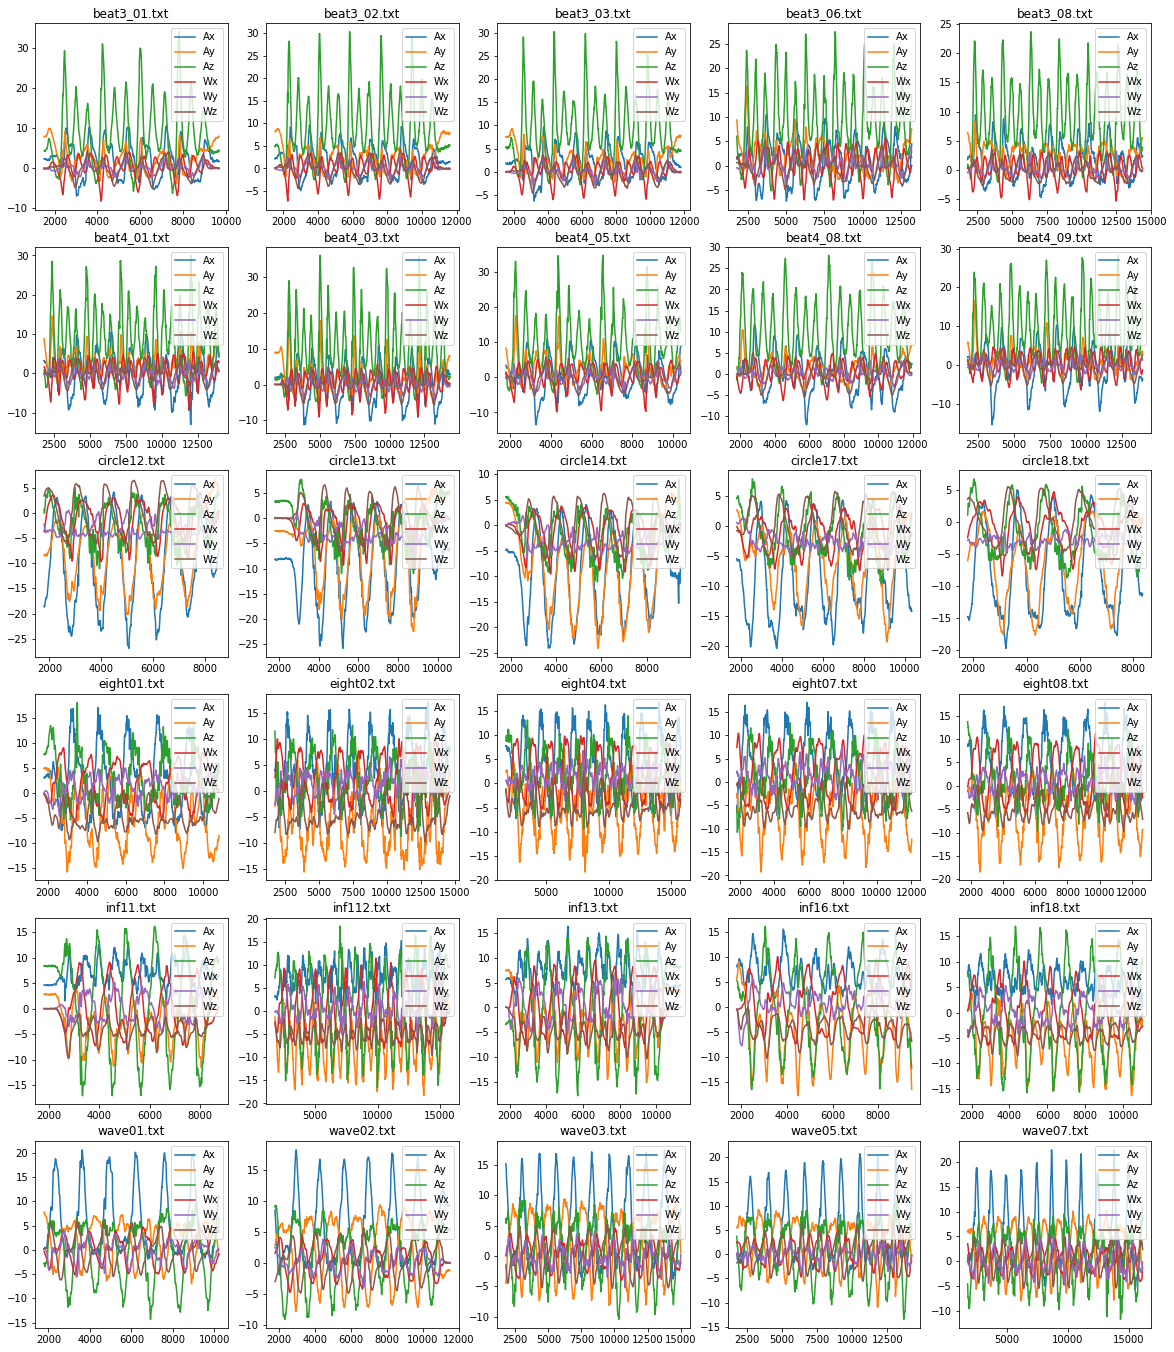

In [4]:
PLT_COL = len(train_X[g])
PLT_ROW = len(gestures)

plt.figure(figsize=[20, 24])
row, col = 0, 1
for g in gestures:
    col = 1
    for d in train_X[g]:
        plt.subplot(PLT_ROW, PLT_COL, row * PLT_COL + col)
        plt.title(train_lists[g][col - 1])
        plt.plot(d[:, 0], d[:, 1:])
        plt.legend(["Ax", "Ay", "Az", "Wx", "Wy", "Wz"], loc=1)
        col += 1
    row += 1

### Preprocessing

#### Smoothing data by Savitzky Golay filter

In [5]:
train_X_smoothed = {}
for g in gestures:
    train_X_smoothed[g] = []
    for d in train_X[g]:
        train_X_smoothed[g].append(savgol_filter(d[:, 1:], window_length=5, polyorder=2, deriv=0, delta=1, mode="interp"))
        print(g, train_X_smoothed[g][-1].shape)


beat3 (1620, 6)
beat3 (2008, 6)
beat3 (2043, 6)
beat3 (2265, 6)
beat3 (2495, 6)
beat4 (2417, 6)
beat4 (2488, 6)
beat4 (1707, 6)
beat4 (2013, 6)
beat4 (2409, 6)
circle (1344, 6)
circle (1754, 6)
circle (1533, 6)
circle (1695, 6)
circle (1301, 6)
eight (1791, 6)
eight (2548, 6)
eight (2771, 6)
eight (2033, 6)
eight (2158, 6)
inf (1383, 6)
inf (2779, 6)
inf (1895, 6)
inf (1525, 6)
inf (1835, 6)
wave (1666, 6)
wave (1926, 6)
wave (2625, 6)
wave (2470, 6)
wave (2843, 6)


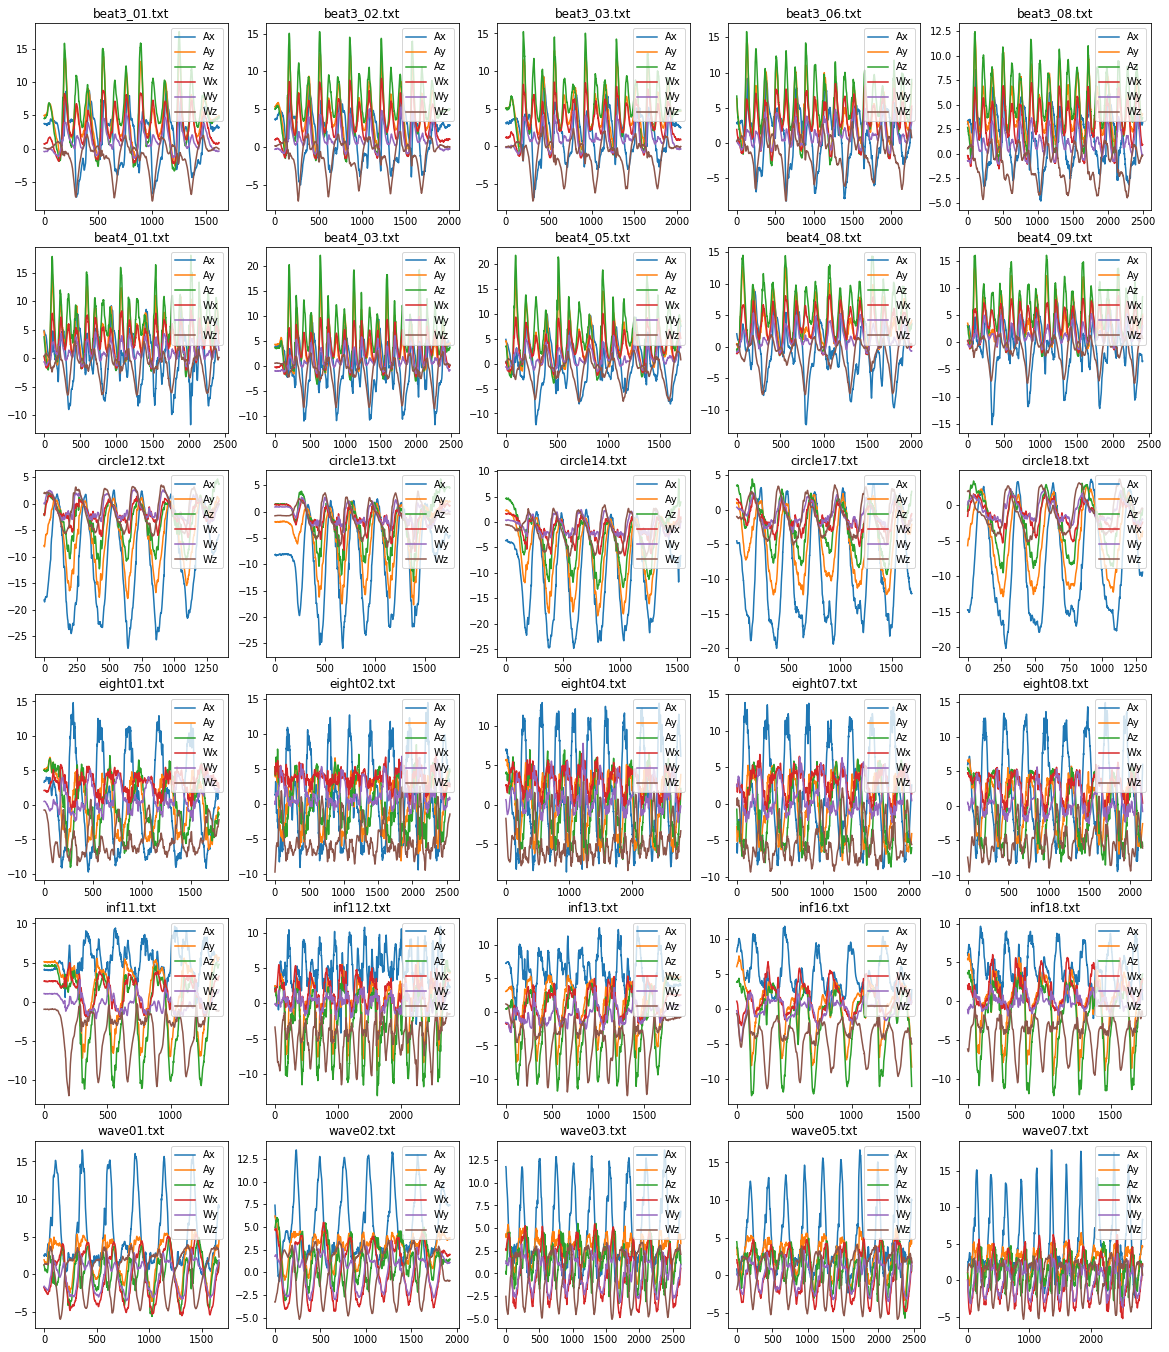

In [6]:
PLT_COL = len(train_X[g])
PLT_ROW = len(gestures)

plt.figure(figsize=[20, 24])
row, col = 0, 1
for g in gestures:
    col = 1
    for d in train_X_smoothed[g]:
        plt.subplot(PLT_ROW, PLT_COL, row * PLT_COL + col)
        plt.title(train_lists[g][col - 1])
        plt.plot(d)
        plt.legend(["Ax", "Ay", "Az", "Wx", "Wy", "Wz"], loc=1)
        col += 1
    row += 1

#### Quantize the sequences by K-means

In [7]:
%%time

# use only 6 axises data
X = None
for g in gestures:
    if X is None:
        X = np.concatenate(train_X_smoothed[g])
    else:
        X = np.concatenate([X, np.concatenate(train_X_smoothed[g])])
print(X.shape)

kmeans = KMeans(n_clusters=20, random_state=0).fit(X)
train_X_quantized = {}
for g in gestures:
    train_X_quantized[g] = []
    for d in train_X_smoothed[g]:
        train_X_quantized[g].append(kmeans.predict(d).reshape(-1, 1))
        print(g, train_X_quantized[g][-1].shape)    

(61340, 6)
beat3 (1620, 1)
beat3 (2008, 1)
beat3 (2043, 1)
beat3 (2265, 1)
beat3 (2495, 1)
beat4 (2417, 1)
beat4 (2488, 1)
beat4 (1707, 1)
beat4 (2013, 1)
beat4 (2409, 1)
circle (1344, 1)
circle (1754, 1)
circle (1533, 1)
circle (1695, 1)
circle (1301, 1)
eight (1791, 1)
eight (2548, 1)
eight (2771, 1)
eight (2033, 1)
eight (2158, 1)
inf (1383, 1)
inf (2779, 1)
inf (1895, 1)
inf (1525, 1)
inf (1835, 1)
wave (1666, 1)
wave (1926, 1)
wave (2625, 1)
wave (2470, 1)
wave (2843, 1)
CPU times: user 15 s, sys: 3.72 s, total: 18.7 s
Wall time: 7.66 s


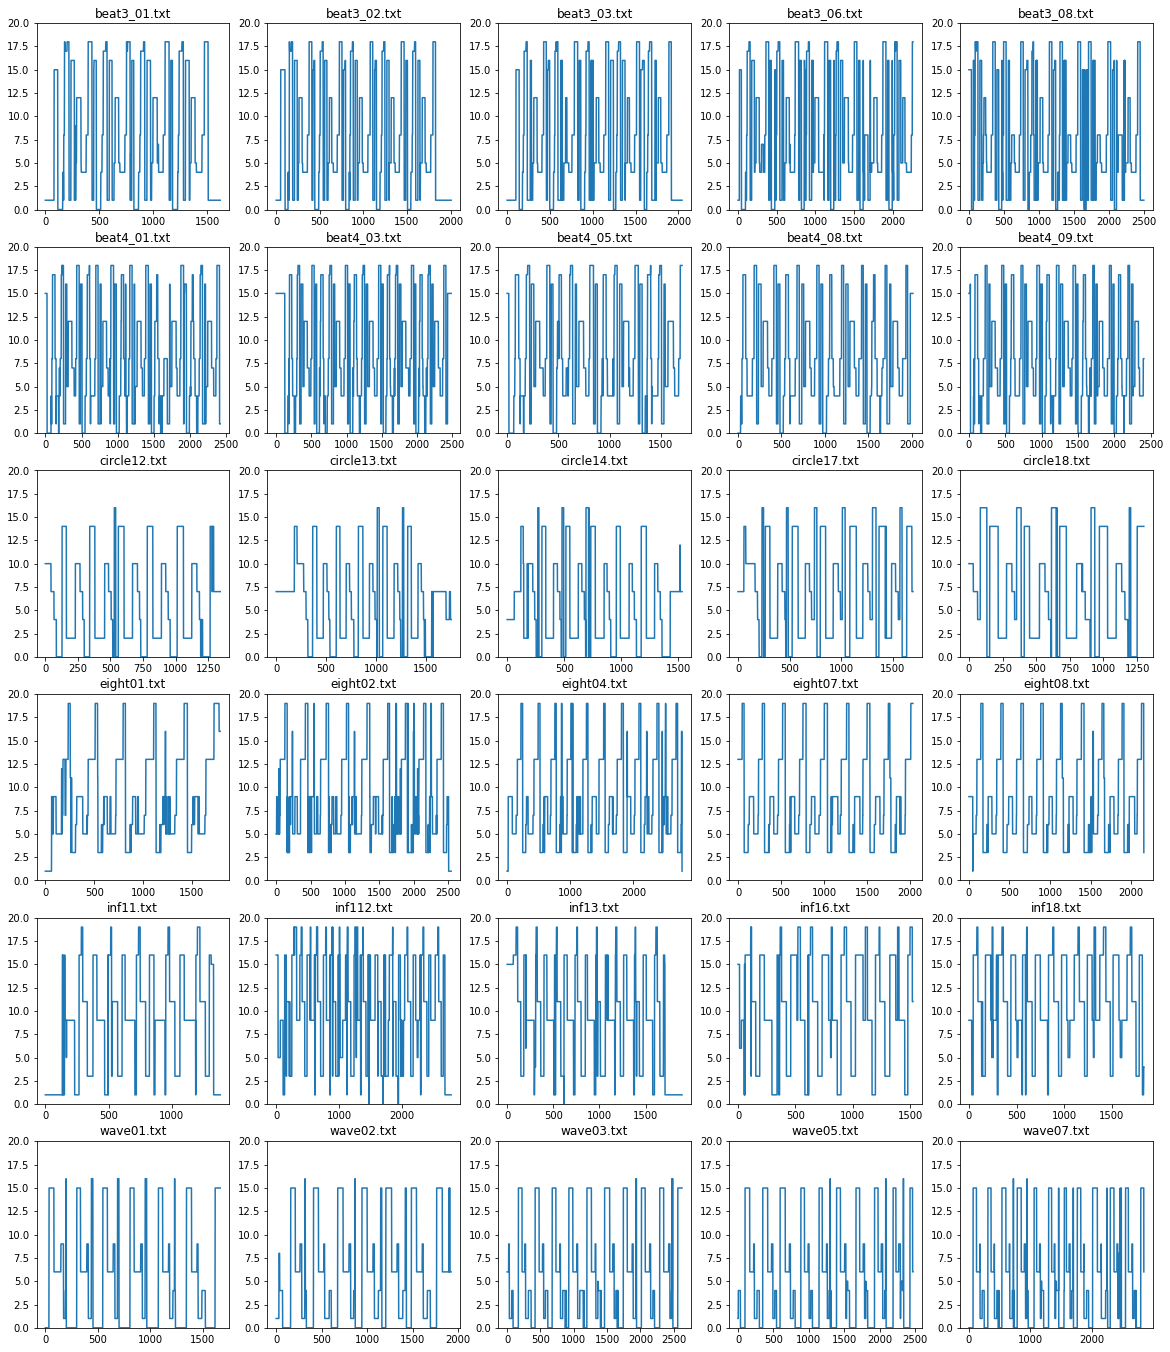

In [ ]:
PLT_COL = len(train_X_quantized[g])
PLT_ROW = len(gestures)

plt.figure(figsize=[20, 24])
row, col = 0, 1
for g in gestures:
    col = 1
    for d in train_X_quantized[g]:
        ax = plt.subplot(PLT_ROW, PLT_COL, row * PLT_COL + col)
        plt.title(train_lists[g][col - 1])
        plt.plot(d)
        ax.set_ylim([0, 20])
        col += 1
    row += 1

### Hold out 20% for cross-validation

In [8]:
split_ratio = 0.2

dev_test_indices = {}
x_train_dev = {}
x_test_dev = {}
file_train_dev = {}
file_test_dev = {}

dev_data = train_X_quantized

for g in gestures:
    test_size = int(len(dev_data[g]) * split_ratio)
    dev_test_indices[g] = sorted(random.sample(range(len(dev_data[g])), test_size))
    x_train_dev[g] = np.array([dev_data[g][i] for i in range(len(dev_data[g])) if i not in dev_test_indices[g]])
    x_test_dev[g] = np.array([dev_data[g][i] for i in range(len(dev_data[g])) if i in dev_test_indices[g]])
    file_train_dev[g] = np.array([train_lists[g][i] for i in range(len(train_lists[g])) if i not in dev_test_indices[g]])
    file_test_dev[g] = np.array([train_lists[g][i] for i in range(len(train_lists[g])) if i in dev_test_indices[g]])

print("Split Ratio:", 0.2)

for g in gestures: 
    print("---------------------------------")
    print(g, "=> test set picked:", dev_test_indices[g])
    print("training set: ", file_train_dev[g])
    print("test set: ", file_test_dev[g])
    

Split Ratio: 0.2
---------------------------------
beat3 => test set picked: [1]
training set:  ['beat3_01.txt' 'beat3_03.txt' 'beat3_06.txt' 'beat3_08.txt'
 'beat3_31.txt']
test set:  ['beat3_02.txt']
---------------------------------
beat4 => test set picked: [1]
training set:  ['beat4_01.txt' 'beat4_05.txt' 'beat4_08.txt' 'beat4_09.txt'
 'beat4_31.txt']
test set:  ['beat4_03.txt']
---------------------------------
circle => test set picked: [4]
training set:  ['circle12.txt' 'circle13.txt' 'circle14.txt' 'circle17.txt'
 'circle31.txt']
test set:  ['circle18.txt']
---------------------------------
eight => test set picked: [4]
training set:  ['eight01.txt' 'eight02.txt' 'eight04.txt' 'eight07.txt' 'eight31.txt']
test set:  ['eight08.txt']
---------------------------------
inf => test set picked: [1]
training set:  ['inf11.txt' 'inf13.txt' 'inf16.txt' 'inf18.txt' 'inf31.txt']
test set:  ['inf112.txt']
---------------------------------
wave => test set picked: [1]
training set:  ['wave

### HMM models for gesture recognition

#### Benchmark: HMM from Sklearn

In [9]:
# %%time

# dev_models = {}
# for g in gestures:
#     dev_models[g] = hmm.GaussianHMM(n_components=10, covariance_type="diag")
#     dev_models[g].fit(np.concatenate(x_train_dev[g]))

#### Self-Implemented 

In [10]:
%%time

dev_models = {}
for g in gestures:
    dev_models[g] = HMM(10, 20)
    dev_models[g].fit(x_train_dev[g])

Iteration: 1,  Mean Likelihood: -26931.669344063343
Iteration: 2,  Mean Likelihood: -18305.567541994587
Iteration: 3,  Mean Likelihood: -16748.025963449007
Iteration: 4,  Mean Likelihood: -13613.285615442943
Iteration: 5,  Mean Likelihood: -11222.993676632856
Iteration: 6,  Mean Likelihood: -9840.243927902366
Iteration: 7,  Mean Likelihood: -8262.093309663254
Iteration: 8,  Mean Likelihood: -7018.533766996136
Iteration: 9,  Mean Likelihood: -6792.860163274632
Iteration: 10,  Mean Likelihood: -6693.919149892801
Iteration: 11,  Mean Likelihood: -6666.6293036409
Iteration: 12,  Mean Likelihood: -6648.841044669971
Iteration: 13,  Mean Likelihood: -6644.50887977764
Iteration: 14,  Mean Likelihood: -6642.073150477163
Iteration: 15,  Mean Likelihood: -6639.684716125773
Iteration: 16,  Mean Likelihood: -6637.14808937604
Iteration: 17,  Mean Likelihood: -6634.316004194785
Iteration: 18,  Mean Likelihood: -6631.017445665644
Iteration: 19,  Mean Likelihood: -6627.060793559457
Iteration: 20,  Mean

Iteration: 158,  Mean Likelihood: -6583.638879756398
Iteration: 159,  Mean Likelihood: -6583.620006859008
Iteration: 160,  Mean Likelihood: -6583.600960814759
Iteration: 161,  Mean Likelihood: -6583.581740814929
Iteration: 162,  Mean Likelihood: -6583.562346338901
Iteration: 163,  Mean Likelihood: -6583.542777170949
Iteration: 164,  Mean Likelihood: -6583.5230334151065
Iteration: 165,  Mean Likelihood: -6583.5031155076695
Iteration: 166,  Mean Likelihood: -6583.483024226695
Iteration: 167,  Mean Likelihood: -6583.462760698045
Iteration: 168,  Mean Likelihood: -6583.442326397446
Iteration: 169,  Mean Likelihood: -6583.421723148114
Iteration: 170,  Mean Likelihood: -6583.400953113585
Iteration: 171,  Mean Likelihood: -6583.380018785381
Iteration: 172,  Mean Likelihood: -6583.358922965337
Iteration: 173,  Mean Likelihood: -6583.337668742439
Iteration: 174,  Mean Likelihood: -6583.316259464196
Iteration: 175,  Mean Likelihood: -6583.294698702621
Iteration: 176,  Mean Likelihood: -6583.2729

KeyboardInterrupt: 

#### Predict

In [11]:
correct = 0
for g in gestures:
    print("--------", g, "---------")
    scores = np.array([dev_models[m_g].score(x_test_dev[g][0]) for m_g in gestures])
    for i in range(len(scores)):
        print("{:6} ->  {}".format(gestures[i], scores[i]))
        
    y_pred = gestures[np.argmax(scores)]
    print("Predict:", y_pred, "\n")
    if y_pred == g:
        correct += 1

print("accuracy: ", float(correct) / len(gestures))

-------- beat3 ---------


AttributeError: 'NoneType' object has no attribute 'shape'

### Final model training and save to local

In [ ]:
model_dir = './models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

#### K-means

In [ ]:
dump(kmeans, model_dir + 'kmeans.joblib') 

['./models/kmeans.joblib']

#### Benchmark: HMM from Sklearn

In [ ]:
# %%time

# models = {}
# for g in gestures:
#     models[g] = hmm.GaussianHMM(n_components=10, covariance_type="diag")
#     models[g].fit(np.concatenate(train_X_smoothed[g]))
#     dump(models[g], model_dir + g + '.joblib') 

#### Self-Implemented 

In [ ]:
%%time

models = {}
for g in gestures:
    models[g] = HMM(10, 20)
    models[g].fit(train_X_quantized[g])

Iteration: 1,  Mean Likelihood: -31436.902796709663
Iteration: 2,  Mean Likelihood: -22816.054529920384
Iteration: 3,  Mean Likelihood: -22382.54689124668
Iteration: 4,  Mean Likelihood: -21184.918705231044
Iteration: 5,  Mean Likelihood: -18987.969642145224
Iteration: 6,  Mean Likelihood: -16249.345044523412
Iteration: 7,  Mean Likelihood: -12409.208627552012
Iteration: 8,  Mean Likelihood: -9129.597852520386
Iteration: 9,  Mean Likelihood: -7931.481480998267
Iteration: 10,  Mean Likelihood: -7538.083409687374
Iteration: 11,  Mean Likelihood: -6894.907460909297
Iteration: 12,  Mean Likelihood: -6669.484100186596
Iteration: 13,  Mean Likelihood: -6637.290582143825
Iteration: 14,  Mean Likelihood: -6632.255208552927
Iteration: 15,  Mean Likelihood: -6614.471378475711
Iteration: 16,  Mean Likelihood: -6239.682247223731
Iteration: 17,  Mean Likelihood: -5782.000888537141
Iteration: 18,  Mean Likelihood: -5766.171308558158
Iteration: 19,  Mean Likelihood: -5764.547650122943
Iteration: 20, 

Iteration: 9,  Mean Likelihood: -8677.185502767159
Iteration: 10,  Mean Likelihood: -8506.798601856313
Iteration: 11,  Mean Likelihood: -8400.41319869693
Iteration: 12,  Mean Likelihood: -8396.628064863238
Iteration: 13,  Mean Likelihood: -8395.898293987628
Iteration: 14,  Mean Likelihood: -8395.307820432194
Iteration: 15,  Mean Likelihood: -8394.817529404052
Iteration: 16,  Mean Likelihood: -8394.3740748347
Iteration: 17,  Mean Likelihood: -8393.955547333446
Iteration: 18,  Mean Likelihood: -8393.557092796727
Iteration: 19,  Mean Likelihood: -8393.177102217722
Iteration: 20,  Mean Likelihood: -8392.813112750264
Iteration: 21,  Mean Likelihood: -8392.461856849626
Iteration: 22,  Mean Likelihood: -8392.1201692577
Iteration: 23,  Mean Likelihood: -8391.785601884729
Iteration: 24,  Mean Likelihood: -8391.456483827826
Iteration: 25,  Mean Likelihood: -8391.131534033757
Iteration: 26,  Mean Likelihood: -8390.809311152516
Iteration: 27,  Mean Likelihood: -8390.487788052144
Iteration: 28,  Me

Iteration: 166,  Mean Likelihood: -6747.158012697737
Iteration: 167,  Mean Likelihood: -6747.154898589338
Iteration: 168,  Mean Likelihood: -6747.151841114299
Iteration: 169,  Mean Likelihood: -6747.148837813137
Iteration: 170,  Mean Likelihood: -6747.1458863976695
Iteration: 171,  Mean Likelihood: -6747.142984736965
Iteration: 172,  Mean Likelihood: -6747.140130844491
Iteration: 173,  Mean Likelihood: -6747.137322866405
Iteration: 174,  Mean Likelihood: -6747.13455907086
Iteration: 175,  Mean Likelihood: -6747.131837838211
Iteration: 176,  Mean Likelihood: -6747.129157652109
Iteration: 177,  Mean Likelihood: -6747.126517091335
Iteration: 178,  Mean Likelihood: -6747.12391482233
Iteration: 179,  Mean Likelihood: -6747.121349592396
Iteration: 180,  Mean Likelihood: -6747.118820223443
Iteration: 181,  Mean Likelihood: -6747.116325606286
Iteration: 182,  Mean Likelihood: -6747.113864695421
Iteration: 183,  Mean Likelihood: -6747.111436504232
Iteration: 184,  Mean Likelihood: -6747.1090401

Iteration: 44,  Mean Likelihood: -2063.8636053662126
Iteration: 45,  Mean Likelihood: -2063.8462236280034
Iteration: 46,  Mean Likelihood: -2063.8287077031496
Iteration: 47,  Mean Likelihood: -2063.811057122548
Iteration: 48,  Mean Likelihood: -2063.793273657405
Iteration: 49,  Mean Likelihood: -2063.775361098942
Iteration: 50,  Mean Likelihood: -2063.7573250492073
Iteration: 51,  Mean Likelihood: -2063.7391727200966
Iteration: 52,  Mean Likelihood: -2063.7209127388705
Iteration: 53,  Mean Likelihood: -2063.7025549593354
Iteration: 54,  Mean Likelihood: -2063.6841102785324
Iteration: 55,  Mean Likelihood: -2063.6655904592144
Iteration: 56,  Mean Likelihood: -2063.6470079587366
Iteration: 57,  Mean Likelihood: -2063.6283757651577
Iteration: 58,  Mean Likelihood: -2063.6097072414696
Iteration: 59,  Mean Likelihood: -2063.5910159788336
Iteration: 60,  Mean Likelihood: -2063.5723156596846
Iteration: 61,  Mean Likelihood: -2063.5536199314297
Iteration: 62,  Mean Likelihood: -2063.5349422913

Iteration: 199,  Mean Likelihood: -2061.5518628756213
Iteration: 200,  Mean Likelihood: -2061.5261094477373
Iteration: 201,  Mean Likelihood: -2061.4996867336895
Iteration: 202,  Mean Likelihood: -2061.472566054557
Iteration: 203,  Mean Likelihood: -2061.444716953856
Iteration: 204,  Mean Likelihood: -2061.416107026793
Iteration: 205,  Mean Likelihood: -2061.3867017298076
Iteration: 206,  Mean Likelihood: -2061.3564641678204
Iteration: 207,  Mean Likelihood: -2061.3253548562056
Iteration: 208,  Mean Likelihood: -2061.293331454088
Iteration: 209,  Mean Likelihood: -2061.260348464955
Iteration: 210,  Mean Likelihood: -2061.226356900007
Iteration: 211,  Mean Likelihood: -2061.1913038988764
Iteration: 212,  Mean Likelihood: -2061.1551323015187
Iteration: 213,  Mean Likelihood: -2061.1177801640183
Iteration: 214,  Mean Likelihood: -2061.0791802099075
Iteration: 215,  Mean Likelihood: -2061.0392592071944
Iteration: 216,  Mean Likelihood: -2060.9979372597245
Iteration: 217,  Mean Likelihood: 

Iteration: 353,  Mean Likelihood: -2052.0947765461424
Iteration: 354,  Mean Likelihood: -2052.0893363627247
Iteration: 355,  Mean Likelihood: -2052.0838501181315
Iteration: 356,  Mean Likelihood: -2052.078316902541
Iteration: 357,  Mean Likelihood: -2052.072735778111
Iteration: 358,  Mean Likelihood: -2052.067105777838
Iteration: 359,  Mean Likelihood: -2052.0614259043796
Iteration: 360,  Mean Likelihood: -2052.0556951288077
Iteration: 361,  Mean Likelihood: -2052.049912389328
Iteration: 362,  Mean Likelihood: -2052.0440765899302
Iteration: 363,  Mean Likelihood: -2052.038186598979
Iteration: 364,  Mean Likelihood: -2052.032241247747
Iteration: 365,  Mean Likelihood: -2052.026239328871
Iteration: 366,  Mean Likelihood: -2052.020179594746
Iteration: 367,  Mean Likelihood: -2052.014060755834
Iteration: 368,  Mean Likelihood: -2052.0078814788953
Iteration: 369,  Mean Likelihood: -2052.001640385135
Iteration: 370,  Mean Likelihood: -2051.995336048256
Iteration: 371,  Mean Likelihood: -2051

Iteration: 2,  Mean Likelihood: -21077.654108002178
Iteration: 3,  Mean Likelihood: -20381.845611210047
Iteration: 4,  Mean Likelihood: -18529.504331041884
Iteration: 5,  Mean Likelihood: -15420.878084440039
Iteration: 6,  Mean Likelihood: -10771.359844690121
Iteration: 7,  Mean Likelihood: -7417.506383023015
Iteration: 8,  Mean Likelihood: -6876.519035533898
Iteration: 9,  Mean Likelihood: -6782.905580566722
Iteration: 10,  Mean Likelihood: -6522.421518204339
Iteration: 11,  Mean Likelihood: -5673.166041804239
Iteration: 12,  Mean Likelihood: -5345.009624516654
Iteration: 13,  Mean Likelihood: -5223.4352719159215
Iteration: 14,  Mean Likelihood: -4806.375050649647
Iteration: 15,  Mean Likelihood: -3761.344903891102
Iteration: 16,  Mean Likelihood: -3251.7479774381736
Iteration: 17,  Mean Likelihood: -3230.6659137882402
Iteration: 18,  Mean Likelihood: -3227.895407084098
Iteration: 19,  Mean Likelihood: -3225.1598120467474
Iteration: 20,  Mean Likelihood: -3221.2403744167714
Iteration:

Iteration: 101,  Mean Likelihood: -3626.175682576313
Iteration: 102,  Mean Likelihood: -3626.1624242510075
Iteration: 103,  Mean Likelihood: -3626.149309642461
Iteration: 104,  Mean Likelihood: -3626.1363341848005
Iteration: 105,  Mean Likelihood: -3626.1234932327307
Iteration: 106,  Mean Likelihood: -3626.11078207439
Iteration: 107,  Mean Likelihood: -3626.0981959436244
Iteration: 108,  Mean Likelihood: -3626.0857300316693
Iteration: 109,  Mean Likelihood: -3626.073379498196
Iteration: 110,  Mean Likelihood: -3626.0611394816733
Iteration: 111,  Mean Likelihood: -3626.049005109031
Iteration: 112,  Mean Likelihood: -3626.036971504647
Iteration: 113,  Mean Likelihood: -3626.025033798604
Iteration: 114,  Mean Likelihood: -3626.013187134279
Iteration: 115,  Mean Likelihood: -3626.0014266752255
Iteration: 116,  Mean Likelihood: -3625.9897476114115
Iteration: 117,  Mean Likelihood: -3625.9781451648128
Iteration: 118,  Mean Likelihood: -3625.966614594368
Iteration: 119,  Mean Likelihood: -362

Iteration: 255,  Mean Likelihood: -3623.34026068133
Iteration: 256,  Mean Likelihood: -3623.297194258077
Iteration: 257,  Mean Likelihood: -3623.253414347291
Iteration: 258,  Mean Likelihood: -3623.2089084637846
Iteration: 259,  Mean Likelihood: -3623.163663726605
Iteration: 260,  Mean Likelihood: -3623.117666825285
Iteration: 261,  Mean Likelihood: -3623.0709039853896
Iteration: 262,  Mean Likelihood: -3623.0233609335905
Iteration: 263,  Mean Likelihood: -3622.975022862415
Iteration: 264,  Mean Likelihood: -3622.9258743948894
Iteration: 265,  Mean Likelihood: -3622.875899549254
Iteration: 266,  Mean Likelihood: -3622.825081703902
Iteration: 267,  Mean Likelihood: -3622.7734035627127
Iteration: 268,  Mean Likelihood: -3622.720847120918
Iteration: 269,  Mean Likelihood: -3622.667393631591
Iteration: 270,  Mean Likelihood: -3622.6130235729133
Iteration: 271,  Mean Likelihood: -3622.5577166162175
Iteration: 272,  Mean Likelihood: -3622.5014515949315
Iteration: 273,  Mean Likelihood: -3622

Iteration: 5,  Mean Likelihood: -10313.998024992556
Iteration: 6,  Mean Likelihood: -8353.32857637381
Iteration: 7,  Mean Likelihood: -5749.398196723358
Iteration: 8,  Mean Likelihood: -4619.214261023286
Iteration: 9,  Mean Likelihood: -4539.150863363715
Iteration: 10,  Mean Likelihood: -4520.161691522875
Iteration: 11,  Mean Likelihood: -4515.13147660966
Iteration: 12,  Mean Likelihood: -4512.834288524947
Iteration: 13,  Mean Likelihood: -4511.242909226979
Iteration: 14,  Mean Likelihood: -4510.041495574133
Iteration: 15,  Mean Likelihood: -4509.082803202335
Iteration: 16,  Mean Likelihood: -4508.283740861127
Iteration: 17,  Mean Likelihood: -4507.59288953284
Iteration: 18,  Mean Likelihood: -4506.976037156412
Iteration: 19,  Mean Likelihood: -4506.408565691587
Iteration: 20,  Mean Likelihood: -4505.871049782872
Iteration: 21,  Mean Likelihood: -4505.346459087818
Iteration: 22,  Mean Likelihood: -4504.818124642554
Iteration: 23,  Mean Likelihood: -4504.267965172383
Iteration: 24,  Mea

In [ ]:
dump(models, model_dir + 'hmm_models.joblib') 